In [ ]:
# Department: ESTSOFT
# Class: AI Modelling
# Category: Machine learning
# Title: Ice Extent Prediction
# Contributors: Kimm Soo Min
# Last modified date: 09/05/25

# Reference:
# https://github.com/eriklindernoren/PyTorch-GAN
# https://github.com/lucidrains/unet-stylegan2
# https://www.tensorflow.org/tutorials/generative/pix2pix

In [2]:
# Library
import numpy as np
import pandas as pd
from pandas import date_range
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import re
from datetime import datetime
import glob
import os
import torch
from torch import nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision.utils import save_image
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm
import argparse


In [3]:
# Device agnostic code
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
# Dataset for images
class ImageDataset(Dataset):
    def __init__(self, folder, start_date='1978-11', end_date='2025-04', indices=None):
        self.folder = folder
        self.dates = pd.date_range(start=start_date, end=end_date, freq='MS')
        self.indices = indices if indices is not None else range(len(self.dates) - 12)
        self.transform = T.ToTensor() # [0, 255] -> [0, 1]

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, i):
        idx = self.indices[i]
        imgs = []
        for j in range(12):
            date = self.dates[idx + j]
            path = os.path.join(self.folder, f"image_grey/256x256/img_grey_{date.year}{date.month:02d}.png")
            img = self.transform(Image.open(path))
            imgs.append(img)
        x = torch.cat(imgs, dim=0) # (12, 256, 256)

        date = self.dates[idx + 12]
        path = os.path.join(self.folder, f"image_grey/256x256/img_grey_{date.year}{date.month:02d}.png")
        y = self.transform(Image.open(path)) # (1, 256, 256)

        return x, y

In [9]:
# Generator of GAN
class Generator(nn.Module):
    def __init__(self, in_channels=12, out_channels=1, features=64):
        super().__init__()

        def block_down(in_channels, out_channels, first=False):
            layers = [nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)]
            if not first:
                layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.LeakyReLU(0.2))
            return nn.Sequential(*layers)

        def block_up(in_channels, out_channels, last=False):
            layers = [nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)]
            if not last:
                layers.append(nn.BatchNorm2d(out_channels))
                layers.append(nn.ReLU())
            else:
                layers.append(nn.Sigmoid())
            return nn.Sequential(*layers)

        self.down_1 = block_down(in_channels, features, first=True) # (12, 256, 256) -> (64, 128, 128)
        self.down_2 = block_down(features, features * 2) # (64, 128, 128) -> (128, 64, 64)
        self.down_3 = block_down(features * 2, features * 4) # (128, 64, 64) -> (256, 32, 32)
        self.down_4 = block_down(features * 4, features * 8) # (256, 32, 32) -> (512, 16, 16)
        self.down_5 = block_down(features * 8, features * 8) # (512, 16, 16) -> (512, 8, 8)
        self.down_6 = block_down(features * 8, features * 8) # (512, 8, 8) -> (512, 4, 4)

        self.up_1 = block_up(features * 8, features * 8) # (512, 4, 4) -> (512, 8, 8)
        self.up_2 = block_up(features * 8 * 2, features * 8) # (1024, 8, 8) -> (512, 16, 16) * Due to concatenation, features doubled
        self.up_3 = block_up(features * 8 * 2, features * 4) # (512, 16, 16) -> (256, 32, 32)
        self.up_4 = block_up(features * 4 * 2, features * 2) # (256, 32, 32) -> (128, 64, 64)
        self.up_5 = block_up(features * 2 * 2, features) # (128, 64, 64) -> (64, 128, 128)
        self.up_6 = block_up(features * 2, out_channels, last=True) # (64, 128, 128) -> (1, 256, 256)

    def forward(self, x):
        # Downsampling
        d_1 = self.down_1(x)
        d_2 = self.down_2(d_1)
        d_3 = self.down_3(d_2)
        d_4 = self.down_4(d_3)
        d_5 = self.down_5(d_4)
        d_6 = self.down_6(d_5)

        # Upsampling w/ skip connections
        u_1 = self.up_1(d_6)
        u_2 = self.up_2(torch.cat([u_1, d_5], dim=1))
        u_3 = self.up_3(torch.cat([u_2, d_4], dim=1))
        u_4 = self.up_4(torch.cat([u_3, d_3], dim=1))
        u_5 = self.up_5(torch.cat([u_4, d_2], dim=1))
        u_6 = self.up_6(torch.cat([u_5, d_1], dim=1))

        return u_6

In [10]:
# Discriminator of GAN
class Discriminator(nn.Module):
    def __init__(self, in_channels=13, features=64):
        super().__init__()

        def block(in_channels, out_channels, normalise=True, last=False):
            if last:
                return [nn.Conv2d(in_channels, out_channels, kernel_size=4, padding=1)]
            layers = [nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)]
            if normalise:
                layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.LeakyReLU(0.2))
            return layers

        self.model = nn.Sequential(*block(in_channels, features, normalise=False), # (13, 256, 256) -> (64, 128, 128)
                                   *block(features, features * 2), # (64, 128, 128) -> (128. 64, 64)
                                   *block(features * 2, features * 4), # (128, 64, 64) -> (256, 32, 32)
                                   *block(features * 4, features * 8), # (256, 32, 32) -> (512, 16, 16)
                                   *block(features * 8, 1, last=True)) # (512, 16, 16) -> (1, 15, 15)

    def forward(self, x, y):
        # Input image x.shape = (B, 12, 256, 256)
        # Target (Real or Generated) image y.shape(B, 1, 256, 256)
        return self.model(torch.cat([x, y], dim=1))

In [6]:
# Path
DIR_PATH = "/content/drive/MyDrive/Class/ESTSOFT/project/time_series_analysis/data/southern_hemisphere"

In [11]:
# Data split
data_path = os.path.join(DIR_PATH, "image_grey/256x256")
dataset_full = ImageDataset(data_path)
n = len(dataset_full)

idx_train = list(range(0, int(n * 0.6)))
idx_val = list(range(int(n * 0.6), int(n * 0.8)))
idx_test = list(range(int(n * 0.8), n))

ds_train = ImageDataset(DIR_PATH, indices=idx_train)
ds_val = ImageDataset(DIR_PATH, indices=idx_val)
ds_test = ImageDataset(DIR_PATH, indices=idx_test)

num_workers = os.cpu_count()
dl_train = DataLoader(ds_train, batch_size=2, shuffle=False, pin_memory=True, num_workers=num_workers)
dl_val   = DataLoader(ds_val, batch_size=2, shuffle=False, pin_memory=True, num_workers=num_workers)
dl_test  = DataLoader(ds_test, batch_size=2, shuffle=False, pin_memory=True, num_workers=num_workers)

In [12]:
# Instantiation
gen = torch.compile(Generator()).to(device)
dis = torch.compile(Discriminator()).to(device)

optimizer_gen = torch.optim.Adam(gen.parameters(), lr=1e-4, betas=(0.5, 0.999))
optimizer_dis = torch.optim.Adam(dis.parameters(), lr=1e-4, betas=(0.5, 0.999))

loss_fn_adversarial = nn.BCEWithLogitsLoss() # Fool discriminator
loss_fn_reconstruction = nn.L1Loss() # Be closed to the real image

scaler_gen = GradScaler()
scaler_dis = GradScaler()

<ipython-input-12-d2fd27ab84b8>:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_gen = GradScaler()
/usr/local/lib/python3.11/dist-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
<ipython-input-12-d2fd27ab84b8>:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_dis = GradScaler()


In [ ]:
# Training & Validation
losses_train_gen, losses_train_dis, losses_val = [], [], []
epochs = 100
for epoch in range(epochs):
    # Training
    gen.train()
    dis.train()
    loop = tqdm(dl_train, desc=f"Epoch {epoch + 1}/{epochs}")
    loss_train_gen = 0
    loss_train_dis = 0

    for x, y in loop:
        x_train, y_train = x.to(device, non_blocking=True), y.to(device, non_blocking=True)

        # Discriminator regulisation by adding Gaussian noise
        noise_real = torch.randn_like(y_train) * 0.05
        noise_fake = torch.randn_like(y_train) * 0.05

        # Discriminator
        with autocast():
            y_fake = gen(x_train)

            pred_real = dis(x_train, y_train)
            pred_fake = dis(x_train, y_fake.detach()) # .detach() prevents gradients from flowing back into the Generator

            # Label smoothing

            loss_dis = loss_fn_adversarial(pred_real, torch.ones_like(pred_real)) + loss_fn_adversarial(pred_fake, torch.zeros_like(pred_fake))

        optimizer_dis.zero_grad()
        scaler_dis.scale(loss_dis).backward()
        scaler_dis.step(optimizer_dis)
        scaler_dis.update()
        loss_train_dis += loss_dis.item()

        # Generator
        with autocast():
            pred_fake = dis(x_train, y_fake)
            loss_gen = loss_fn_adversarial(pred_fake, torch.ones_like(pred_fake)) + 100 * loss_fn_reconstruction(y_train, y_fake)

        optimizer_gen.zero_grad()
        scaler_gen.scale(loss_gen).backward()
        scaler_gen.step(optimizer_gen)
        scaler_gen.update()
        loss_train_gen += loss_gen.item()

        loop.set_description(f"Epoch [{epoch + 1}/{epochs}]")
        loop.set_postfix(loss_d=loss_dis.item(), loss_g=loss_gen.item())

    losses_train_gen.append(loss_train_gen / len(dl_train))
    losses_train_dis.append(loss_train_dis / len(dl_train))

    # Validation
    gen.eval()
    loss_val = 0

    with torch.inference_mode():
        for x, y in dl_val:
            x_val, y_val = x.to(device), y.to(device)
            y_pred = gen(x_val)
            loss = loss_fn_reconstruction(y_val, y_pred)
            loss_val += loss.item()

    losses_val.append(loss_val / len(dl_val))

Epoch 1/100:   0%|          | 0/164 [00:00<?, ?it/s]<ipython-input-10-c819061bc2b3>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
W0509 07:30:30.128000 1519 torch/_inductor/utils.py:1137] [0/0] Not enough SMs to use max_autotune_gemm mode
<ipython-input-10-c819061bc2b3>:29: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch [1/100]:   1%|          | 1/164 [01:11<3:12:59, 71.04s/it, loss_d=1.46, loss_g=37.6]<ipython-input-10-c819061bc2b3>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-10-c819061bc2b3>:29: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch [1/100]:  99%|█████████▉| 163/1

In [ ]:
# Save progress
torch.save({'epoch': epoch,
            'gen_state_dict': gen.state_dict(),
            'dis_state_dict': dis.state_dict(),
            'optimizer_gen_state_dict': optimizer_gen.state_dict(),
            'optimizer_dis_state_dict': optimizer_dis.state_dict(),
            'scaler_gen_state_dict': scaler_gen.state_dict(),
            'scaler_dis_state_dict': scaler_dis.state_dict(),
            'losses_train_gen': losses_train_gen,
            'losses_train_dis': losses_train_dis,
            'losses_val': losses_val,},
           f"{DIR_PATH}/gan_checkpoint.pth")

In [13]:
# Load progress
checkpoint = torch.load(f"{DIR_PATH}/gan_checkpoint.pth", map_location=device)

gen.load_state_dict(checkpoint['gen_state_dict'])
dis.load_state_dict(checkpoint['dis_state_dict'])

optimizer_gen.load_state_dict(checkpoint['optimizer_gen_state_dict'])
optimizer_dis.load_state_dict(checkpoint['optimizer_dis_state_dict'])

scaler_gen.load_state_dict(checkpoint['scaler_gen_state_dict'])
scaler_dis.load_state_dict(checkpoint['scaler_dis_state_dict'])

losses_train_gen = checkpoint['losses_train_gen']
losses_train_dis = checkpoint['losses_train_dis']
losses_val = checkpoint['losses_val']

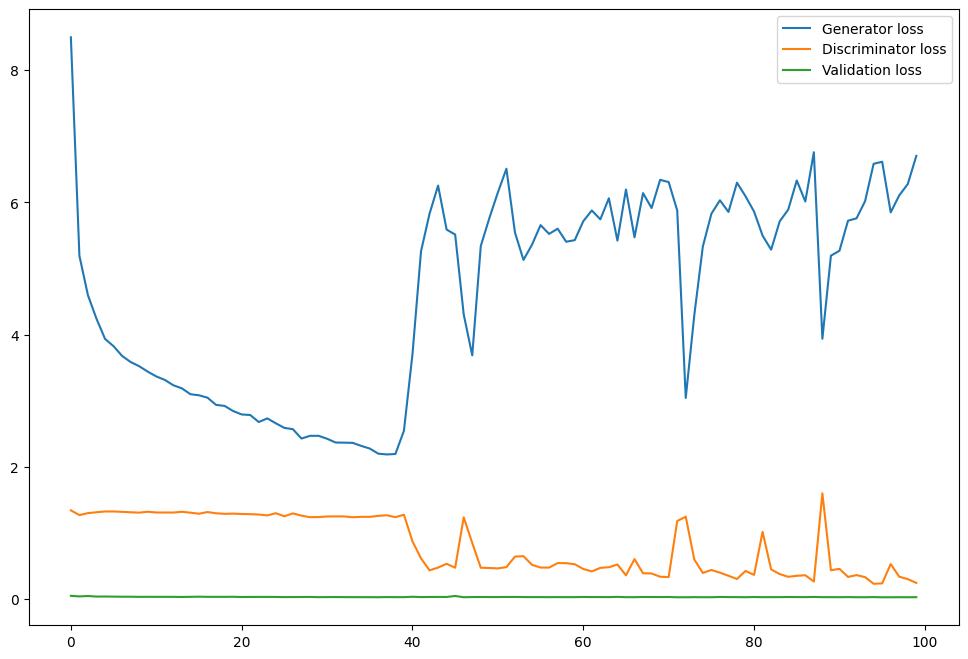

In [20]:
plt.figure(figsize=(12, 8))
plt.plot(losses_train_gen, label="Generator loss")
plt.plot(losses_train_dis, label="Discriminator loss")
plt.plot(losses_val, label="Validation loss")
plt.legend()
plt.show()

In [ ]:
# Testing - Teacher forcing
gen.eval()
os.makedirs(f"{DIR_PATH}/image_teaching", exist_ok=True)
img_path = os.path.join(DIR_PATH, "image_teaching")

with torch.inference_mode():
    for i, (x, y) in enumerate(dl_test):
        x_test, y_test = x.to(device), y.to(device)
        y_pred = gen(x_test)

        for batch in range(x_test.size(0)):
            save_image(y_pred[batch], f"{img_path}/pred_{i}_{batch}.png")
            save_image(y_test[batch], f"{img_path}/true_{i}_{batch}.png")

        if i == 12:
            break

In [ ]:
# Testing - Autoregressive inference
gen.eval()
predictions = []
os.makedirs(f"{DIR_PATH}/image_autoregressive", exist_ok=True)
img_path = os.path.join(DIR_PATH, "image_autoregressive")

# Get the first batch
x_test, y_test = next(iter(dl_test))
x_test, y_test = x_test.to(device), y_test.to(device)
x_curr = x_test[0].unsqueeze(0) # (1, 256, 256) -> (1, 1, 256, 256)

steps = 24
with torch.inference_mode():
    for step in range(steps):
        y_pred = gen(x_curr)

        save_image(y_pred[0], f"{img_path}/pred_{step:02d}.png")

        x_curr = torch.cat([x_curr[:, 1:], y_pred], dim=1) # Sliding window